In [41]:
import random
from gymnasium import Env, spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [42]:
class WarehouseRobotEnv(Env):
    def __init__(self, deterministic=True):
        super().__init__()
        
        self.grid_size = (6, 6)
        self.agent_pos = [0, 0]  
        self.package_positions = [[0, 1], [2, 3], [4, 0]]  # Initial package positions
        self.dropped_package_positions = []  # Track where packages have been dropped
        self.dropoff_pos = [0, 4]  # Fixed dropoff point (yellow block)
        self.obstacles = [[1, 1], [1, 2], [2, 1]]  # Shelves
        self.has_package = False  # Kept for backward compatibility
        self.num_packages = 0  # Number of packages collected
        self.dropped_off = False
        self.trail = []  # To store agent's path
        self.deterministic = deterministic  # Flag to control stochastic or deterministic behavior
        
        # Define action space: Up, Down, Left, Right, Pickup, Dropoff
        self.action_space = spaces.Discrete(6)
        
        # Observation space: (agent_pos, num_packages)
        self.observation_space = spaces.Tuple((
            spaces.MultiDiscrete([6, 6]),
            spaces.Discrete(4)  # 0 to 3 packages
        ))

        # Track cumulative reward
        self.cumulative_reward = 0

    def reset(self):
        self.agent_pos = [0, 0]
        self.package_positions = [[0, 1], [2, 3], [4, 0]]  # Reset package positions
        self.dropped_package_positions = []  # Reset dropped package positions
        self.has_package = False
        self.num_packages = 0
        self.dropped_off = False
        self.trail = []  # Reset trail
        self.cumulative_reward = 0  # Reset cumulative reward
        return self._get_obs(), {}

    def step(self, action):
        reward = -1  # Default step penalty
        terminated = False

        # Store the current position in the trail before moving
        self.trail.append(tuple(self.agent_pos))

        # Movement actions (0-3)
        if action < 4:
            new_pos = self._move_agent(action)
            if not self._is_valid(new_pos):
                reward = -15  # Penalty for invalid move (out of grid)
            elif not self._is_collision(new_pos):
                self.agent_pos = new_pos
            else:
                reward = -20  # Collision penalty

        # Pickup (4)
        elif action == 4:
            if self.num_packages == 3:
                reward = -10  # Higher penalty for trying to exceed capacity
                print("Agent cannot pick up more than 3 packages!")
            elif self.agent_pos in self.package_positions or self.agent_pos in self.dropped_package_positions:
                self.num_packages += 1
                if self.agent_pos in self.package_positions:
                    self.package_positions.remove(self.agent_pos)  # Remove from initial package positions
                else:
                    self.dropped_package_positions.remove(self.agent_pos)  # Remove from dropped package positions
                reward = 25  # Reward for each successful pickup
            else:
                reward = -5  # Penalty for invalid pickup (no package present)
            

        
        
        # Dropoff (5)
        elif action == 5:
            if self.num_packages > 0:
                if self.agent_pos in self.package_positions or self.agent_pos in self.dropped_package_positions:
                    reward = -10  # Penalty for attempting to drop a package on an occupied grid
                else:
                    reward = self.num_packages * 25  # Reward based on the number of packages dropped off
                    self.dropped_package_positions.append(self.agent_pos.copy())  # Mark the package as dropped here
                    self.num_packages = 0  # Reset package count after dropoff
                    
                    # If dropped at the fixed dropoff point, give full reward and terminate
                    if self.agent_pos == self.dropoff_pos:
                        self.dropped_off = True
                        terminated = True
                        reward += 100  # Bonus reward for completing task
            else:
                reward = -5  # Penalty for invalid dropoff

        # Update cumulative reward
        self.cumulative_reward += reward

        # Capture next state
        next_state = self._get_obs()
        
        # Render environment state
        self.render()

        return next_state, reward, terminated, False, {}

    def _get_obs(self):
        return (tuple(self.agent_pos), self.num_packages)

    def _move_agent(self, action):
        if self.deterministic or random.random() < 0.9:
            # 90% chance: execute the intended move
            moves = {
                0: [1, 0],  # Up
                1: [-1, 0],   # Down
                2: [0, -1],  # Left
                3: [0, 1]    # Right
            }
            delta = moves[action]
            new_pos = [
                self.agent_pos[0] + delta[0],
                self.agent_pos[1] + delta[1]
            ]
        else:
            # 10% chance: stay in the current position
            new_pos = self.agent_pos.copy()
        
        return new_pos

    def _is_collision(self, pos):
        return pos in self.obstacles
    
    def _is_valid(self, pos):
        x, y = pos
        return 0 <= x < 6 and 0 <= y < 6 and pos not in self.obstacles

    def render(self):
        fig, axs = plt.subplots(1, 2, figsize=(7.5, 4))
        ax = axs[0]
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        # Draw grid
        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        # Draw obstacles
        for obs in self.obstacles:
            ax.add_patch(Rectangle(
                (obs[1], obs[0]), 1, 1, facecolor='black'
            ))

        # Draw packages
        for package in self.package_positions:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='green'))
        
        # Draw dropped packages (show dropped locations in green)
        for dropped_package in self.dropped_package_positions:
            ax.add_patch(Rectangle((dropped_package[1], dropped_package[0]), 1, 1, facecolor='green'))
        
        # Draw dropoff point
        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))

        # Determine agent color based on the number of packages
        agent_colors = {
            0: (1, 0, 0, 0.3),  # Red (transparent)
            1: 'orange',        # 1 package
            2: 'yellow',        # 2 packages
            3: 'blue'           # 3 packages
        }
        agent_color = agent_colors[self.num_packages]

        # Draw agent
        ax.add_patch(Rectangle(
            (self.agent_pos[1], self.agent_pos[0]), 1, 1, facecolor=agent_color
        ))
        ax.set_title("Warehouse Robot Environment")
        
        # Adjusting the grid layout to match visualization
        grid = [[". " for _ in range(6)] for _ in range(6)]
        
        # Place obstacles
        for obs in self.obstacles:
            grid[5 - obs[0]][obs[1]] = "X "  # Obstacle
        
        # Place packages
        for package in self.package_positions:
            grid[5 - package[0]][package[1]] = "P "
        
        # Place dropped packages
        for dropped_package in self.dropped_package_positions:
            grid[5 - dropped_package[0]][dropped_package[1]] = "P "
        
        # Place dropoff point
        grid[5 - self.dropoff_pos[0]][self.dropoff_pos[1]] = "D "
        
        # Place agent
        grid_symbols = {0: "A ", 1: "A1", 2: "A2", 3: "A3"}
        grid[5 - self.agent_pos[0]][self.agent_pos[1]] = grid_symbols[self.num_packages]
        
        # Display grid state as text output
        axs[1].axis('off')
        grid_text = "\n".join(["".join(row) for row in grid])
        axs[1].text(0.5, 0.5, grid_text, fontsize=12, family='monospace', ha='center', va='center')
        axs[1].set_title("Grid Layout")
        
        plt.tight_layout()
        plt.show()

In [43]:
# Simulation function
def run_simulation(deterministic=True, num_steps=100):
    env = WarehouseRobotEnv(deterministic=deterministic)
    obs, _ = env.reset()
    
    print("Initial Grid:")
    env.render()
    
    for step in range(num_steps):
        action = env.action_space.sample()  # Random action
        obs, reward, done, _, _ = env.step(action)
        action_map = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right', 4: 'Pickup', 5: 'Dropoff'}
        
        print(f"Step: {step + 1}")
        print(f"Action: {action} ({action_map[action]})")
        print(f"Reward: {reward}")
        print(f"Cumulative Reward: {env.cumulative_reward}")
        print(f"Agent Position: {obs[0]}")
        print(f"Has Picked Up: {bool(obs[1])}\n")
        
        if done:
            print("Episode finished!")
            break

# DETERMINISTIC

Deterministic Simulation:
Initial Grid:


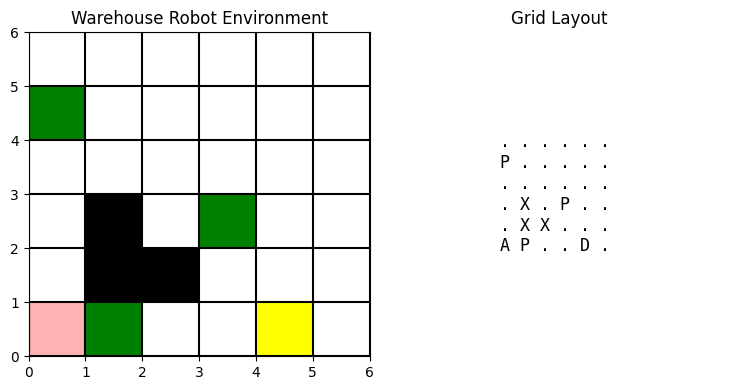

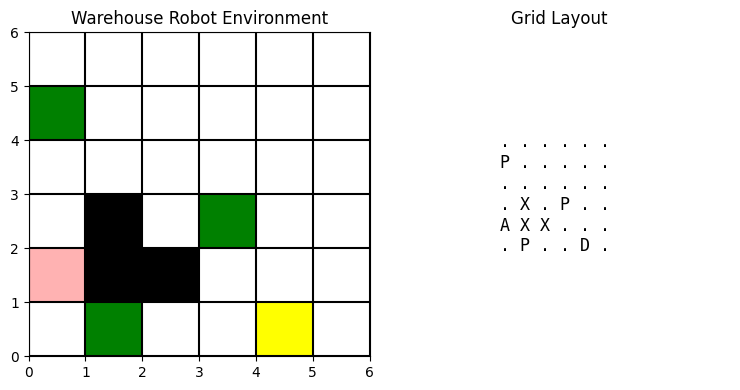

Step: 1
Action: 0 (Up)
Reward: -1
Cumulative Reward: -1
Agent Position: (1, 0)
Has Picked Up: False



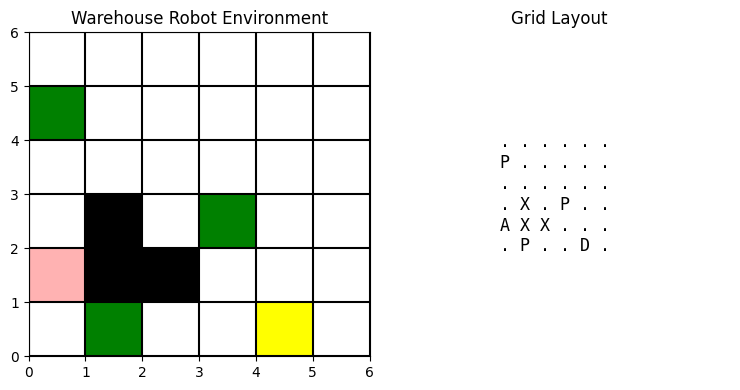

Step: 2
Action: 3 (Right)
Reward: -15
Cumulative Reward: -16
Agent Position: (1, 0)
Has Picked Up: False



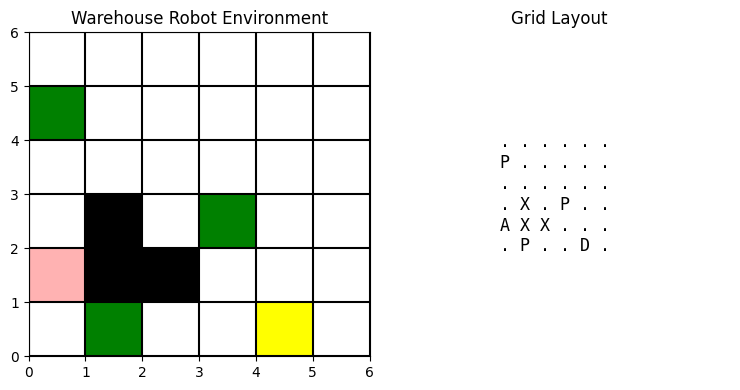

Step: 3
Action: 3 (Right)
Reward: -15
Cumulative Reward: -31
Agent Position: (1, 0)
Has Picked Up: False



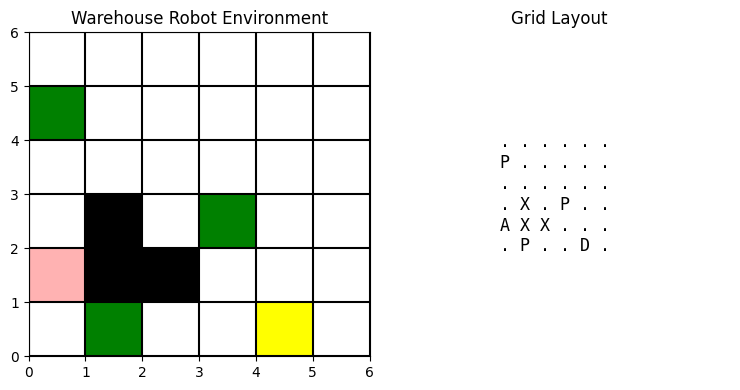

Step: 4
Action: 3 (Right)
Reward: -15
Cumulative Reward: -46
Agent Position: (1, 0)
Has Picked Up: False



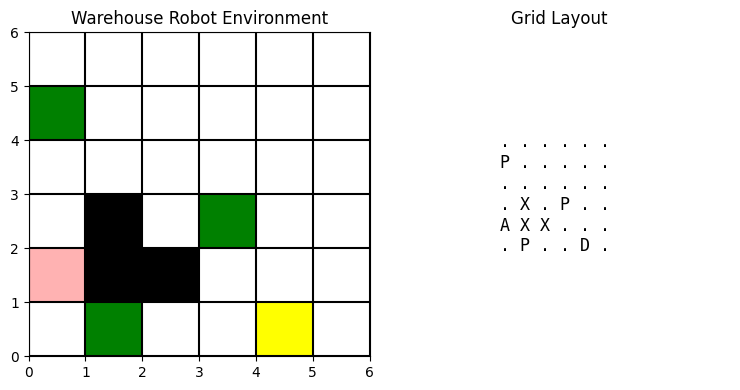

Step: 5
Action: 4 (Pickup)
Reward: -5
Cumulative Reward: -51
Agent Position: (1, 0)
Has Picked Up: False



In [44]:
print("Deterministic Simulation:")
# Run a simulation
run_simulation(deterministic=True, num_steps=5)



# STOCHASTIC


Stochastic Simulation:
Initial Grid:


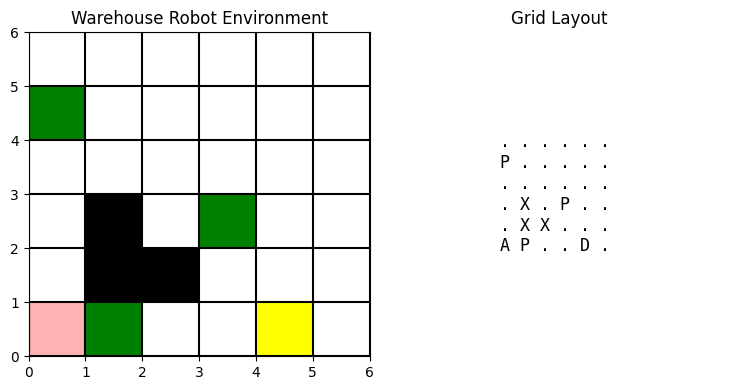

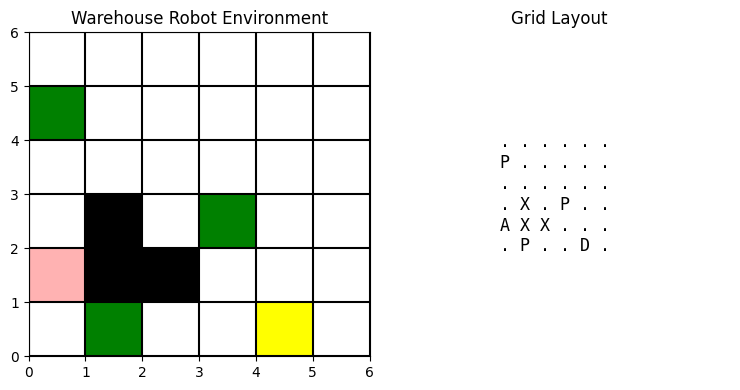

Step: 1
Action: 0 (Up)
Reward: -1
Cumulative Reward: -1
Agent Position: (1, 0)
Has Picked Up: False



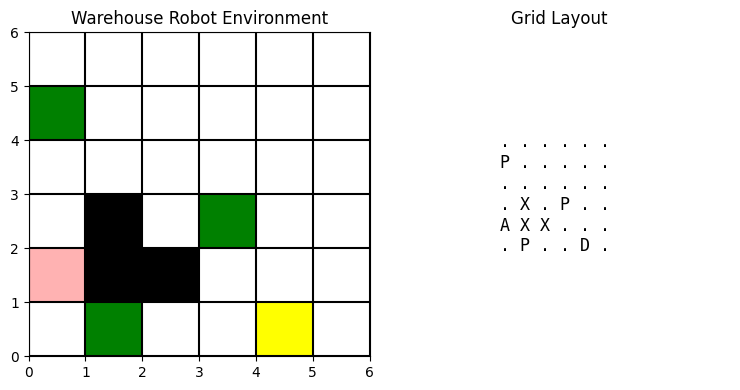

Step: 2
Action: 4 (Pickup)
Reward: -5
Cumulative Reward: -6
Agent Position: (1, 0)
Has Picked Up: False



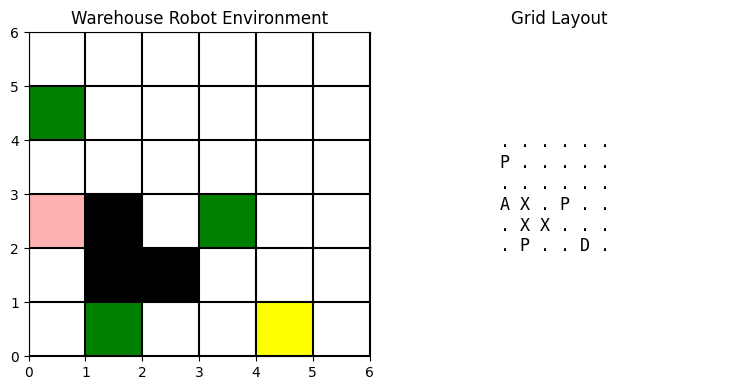

Step: 3
Action: 0 (Up)
Reward: -1
Cumulative Reward: -7
Agent Position: (2, 0)
Has Picked Up: False



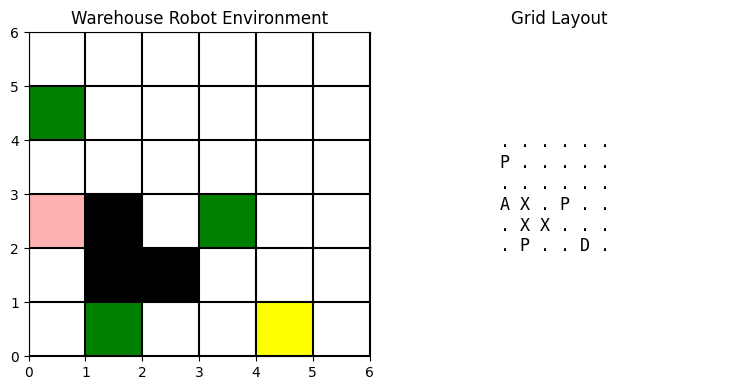

Step: 4
Action: 2 (Left)
Reward: -15
Cumulative Reward: -22
Agent Position: (2, 0)
Has Picked Up: False



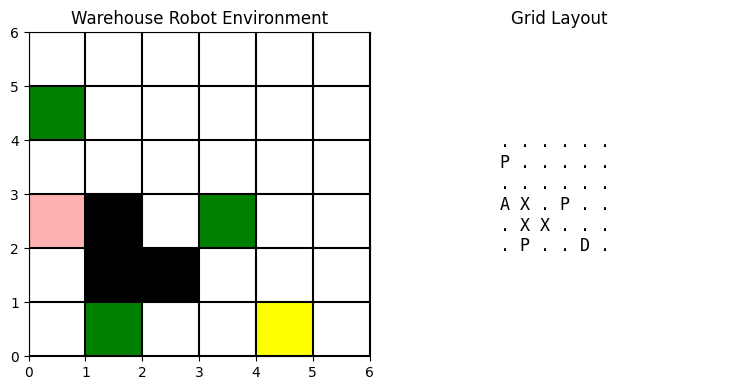

Step: 5
Action: 2 (Left)
Reward: -15
Cumulative Reward: -37
Agent Position: (2, 0)
Has Picked Up: False



In [45]:
# Run stochastic simulation
print("\nStochastic Simulation:")
run_simulation(deterministic=False, num_steps=5)